# Mass forecasting with Facebook's Prophet tool

In this notebook, I will demonstrate how the Prophet tool, open sourced by Facebook in 2017, can create individualized forecasts at scale. This tool allows for more granular forecast becuase we can easily generate highly accurate models for each salesperson or product and location combination. 

In this example I have taken daily climate data for six cities from the NOAA and merged this data with google trends data for the search term 'AC' for the same locations for the 90 day period of 7/3/2020-9/30/2020. This data like many data has multiple autocorrelating trends including weekly trends and an decling overall trend, which is a function of seasonality which is influenced by temperature. 

First I will import, clean, and merge the data into the necessary formating to create forecasts in Prophet. After that I will create forecasts for the search term 'AC' in each of the six cites. 

### Import packages 

In [1]:
import numpy as np
import pandas as pd
import os
import re
from pandas import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import plotly.offline as pyoff
import plotly.graph_objs as go
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import utils
import matplotlib.dates as mdates
from scipy.stats import boxcox
from scipy.special import inv_boxcox

C:\Users\erler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


### Prep google trends files (clean and combine 6 seperate csv files)

In [2]:
path = 'C:/Users/erler/OneDrive/Documents/Random Data Sets/climate/AC/'
files = os.listdir(path)
files = [f for f in files if f[:7] != 'climate'] #skip the NOAA data file
df = pd.DataFrame() 
for f in files:
    data = pd.read_csv(path+f) #read in data
    try:
        headloc = data.loc[data.iloc[:,0]=='Day',:].index[0]
    except: #for some of the files pandas was automatically using the date as the index so I added this section 
        data.reset_index(inplace=True)
        headloc = data.loc[data.iloc[:,0]=='Day',:].index[0]
        
    data.columns = data.iloc[headloc] #set headings
    data = data.iloc[headloc+1:,:]     
    data['city'] = re.sub('[()]', '',data.columns[1:2].astype(str)[0].partition(':')[2][1:]) #create new column with city name
    data.columns = list(data.columns[0:1])+[x[0:x.find(':')] for x in data.columns[1:-1].to_list()]+list(data.columns[-1:]) #clean column names
    df = df.append(data) #stack on the new city
    df['Day'] = df['Day'].astype('datetime64')

df.head()

,Day,AC,city
1,2020-07-03,82,Atlanta GA
2,2020-07-04,72,Atlanta GA
3,2020-07-05,59,Atlanta GA
4,2020-07-06,83,Atlanta GA
5,2020-07-07,71,Atlanta GA


### Prep climate data 

In [3]:
path = 'C:/Users/erler/OneDrive/Documents/Random Data Sets/climate/'
climate = pd.read_csv(path+'climate9.30.csv', header = 0) #import data
climate.NAME = climate.NAME.replace({'NORTHGLENN, CO US':'Denver CO', 'WEST COLUMBIA 1 ESE, TX US':'Houston TX', 'DALLAS 7 NE, GA US':'Atlanta GA', 
'HARRISON, NJ US': 'New York NY', 'LOWER ST. ANTHONY FALLS, MN US':'Minneapolis-St. Paul MN', 
        'SAGUARO NATIONAL PARK, AZ US':'Tucson Sierra Vista AZ'}) #convert locations names to those of google trends 
climate = climate[['DATE', 'NAME','PRCP','TMAX', 'TMIN', 'TOBS']] 
climate.DATE = climate.DATE.astype('datetime64')
climate['MONTH'] = climate['DATE'].dt.month
climate

,DATE,NAME,PRCP,TMAX,TMIN,TOBS,MONTH
0,2020-07-02,Denver CO,0.0,88.0,54.0,63,7
1,2020-07-03,Denver CO,0.0,98.0,60.0,64,7
2,2020-07-04,Denver CO,0.0,93.0,61.0,68,7
3,2020-07-05,Denver CO,0.1,92.0,59.0,69,7
4,2020-07-06,Denver CO,0.0,94.0,58.0,67,7
...,...,...,...,...,...,...,...
528,2020-09-26,Tucson Sierra Vista AZ,0.0,100.0,72.0,76,9
529,2020-09-27,Tucson Sierra Vista AZ,0.0,98.0,71.0,79,9
530,2020-09-28,Tucson Sierra Vista AZ,0.0,97.0,71.0,86,9
531,2020-09-29,Tucson Sierra Vista AZ,0.0,98.0,66.0,76,9


### Merge climate and google trends tables together on date and city 

In [4]:
df = df.merge(climate[['DATE', 'NAME', 'PRCP', 'TMAX', 'TOBS', 'TMIN']], left_on=['Day', 'city'], right_on=['DATE', 'NAME'], 
                      how='left', validate = 'many_to_many')
df.drop(['DATE','NAME'], axis=1, inplace=True)
df = df.fillna(value=0)
df

,Day,AC,city,PRCP,TMAX,TOBS,TMIN
0,2020-07-03,82,Atlanta GA,0.00,91.0,74.0,70.0
1,2020-07-04,72,Atlanta GA,0.00,93.0,75.0,70.0
2,2020-07-05,59,Atlanta GA,0.01,94.0,77.0,70.0
3,2020-07-06,83,Atlanta GA,0.00,92.0,76.0,68.0
4,2020-07-07,71,Atlanta GA,0.17,82.0,75.0,71.0
...,...,...,...,...,...,...,...
535,2020-09-26,47,Tucson Sierra Vista AZ,0.00,100.0,76.0,72.0
536,2020-09-27,33,Tucson Sierra Vista AZ,0.00,98.0,79.0,71.0
537,2020-09-28,25,Tucson Sierra Vista AZ,0.00,97.0,86.0,71.0
538,2020-09-29,32,Tucson Sierra Vista AZ,0.00,98.0,76.0,66.0


### Split data into tables based on city

In [5]:
df = df.rename(columns = {'Day':'ds', 'AC':'y'})

cols = ['ds', 'y', 'PRCP', 'TMAX', 'TOBS', 'TMIN'] #all columns used in location tables
variables = ['y', 'PRCP', 'TMAX', 'TOBS', 'TMIN'] #only numeric columns
df[variables] = df[variables].astype(float)

train_tables = {}
test_tables = {}
tables = {}
for i in df.city.unique():
    df2 = df.loc[df['city']==i]
    df2 = df2[cols]
    train_tables[i] = df2.iloc[:-11,] 
    test_tables[i] = df2.iloc[-12:,] 
    tables[i] = df2 
    
train_tables.keys()

dict_keys(['Atlanta GA', 'Denver CO', 'Houston TX', 'Minneapolis-St. Paul MN', 'New York NY', 'Tucson Sierra Vista AZ'])

### Optimize hyperparameters

In this section I am selecting hyperparameters on all the data combined, rather than optimize hyperparameters for each city since that would be highly time consuming. It's likely that the data is homogeneous enough that there isn't much of a difference from city to city.  

In [6]:
#https://facebook.github.io/prophet/docs/diagnostics.html#parallelizing-cross-validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, .1],
    'seasonality_prior_scale': [0.05, 1.0],
    'changepoint_range':[.8, .9],
    'seasonality_mode':['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df[cols])  # Fit model with given params
    df_cv = cross_validation(m, horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=.5)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-08-06 00:00:00 and 2020-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D00EFD48>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-08-06 00:00:00 and 2020-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D0211908>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-08-06 00:00:00 and 2020-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226CF96CD88>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-08-06 00:00:00 and 2020-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D0119BC8>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs 

    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.05                0.8   
1                     0.001                     0.05                0.8   
2                     0.001                     0.05                0.9   
3                     0.001                     0.05                0.9   
4                     0.001                     1.00                0.8   
5                     0.001                     1.00                0.8   
6                     0.001                     1.00                0.9   
7                     0.001                     1.00                0.9   
8                     0.010                     0.05                0.8   
9                     0.010                     0.05                0.8   
10                    0.010                     0.05                0.9   
11                    0.010                     0.05                0.9   
12                    0.0

### Best hyperparameters are... 

In [7]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'changepoint_range': 0.8, 'seasonality_mode': 'multiplicative'}


### Here is a look at the two underlying trends in the data   

The first trend is the general trend which is declining due to the summer giving way to autumn. We also have the weekly trend, which unsurprisingly, has higher volume on the weekends. If we had a few years worth of data prophet would display  a third plot called yearly trend. The general trend would then display the trend in frequency of google searches for 'AC' after having adjusted for all other underlying trends, which in this case are weekly and yearly trend. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


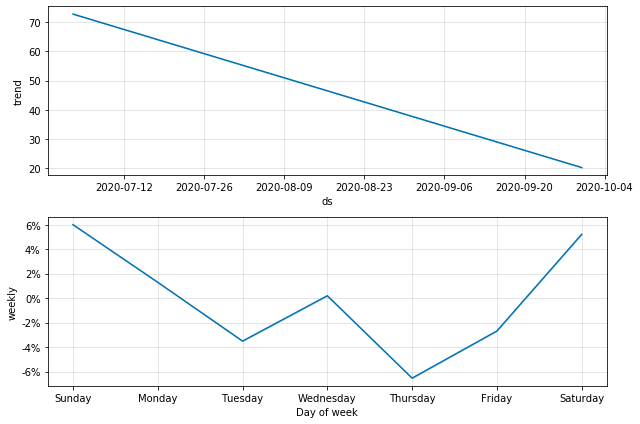

In [8]:
model = Prophet(**best_params)
model.fit(df)
forecast = model.predict(df)
model.plot_components(forecast);

### Forecast without weather data 

Below we will see how the prophet model performs without using additional regressors such as temperature. The shaded area represents a 95% confidence interval and the line in the center represents actual predictions. And although this model has been cross validated, 12 observations (in green) were held out as test data.  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Atlanta GA


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226CF962948>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Denver CO


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D00C4848>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Houston TX


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226CF9FF348>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minneapolis-St. Paul MN


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D0466B48>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


New York NY


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D21EF2C8>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Tucson Sierra Vista AZ


INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-08-05 00:00:00 and 2020-09-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D1AC32C8>


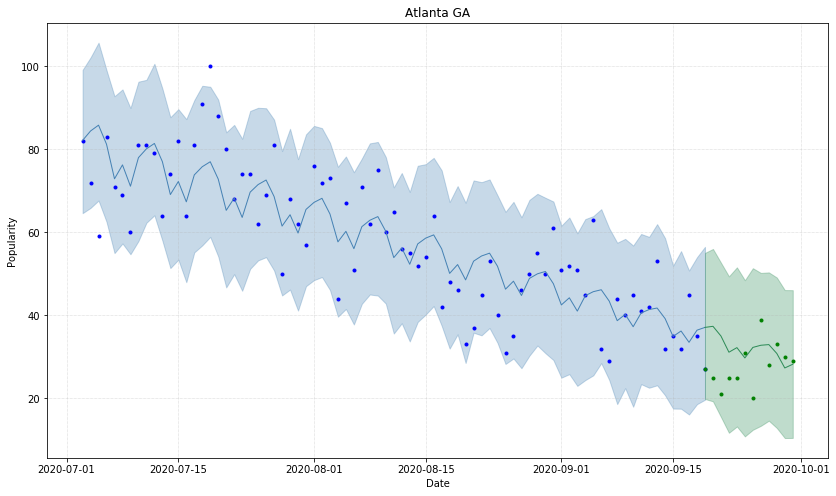

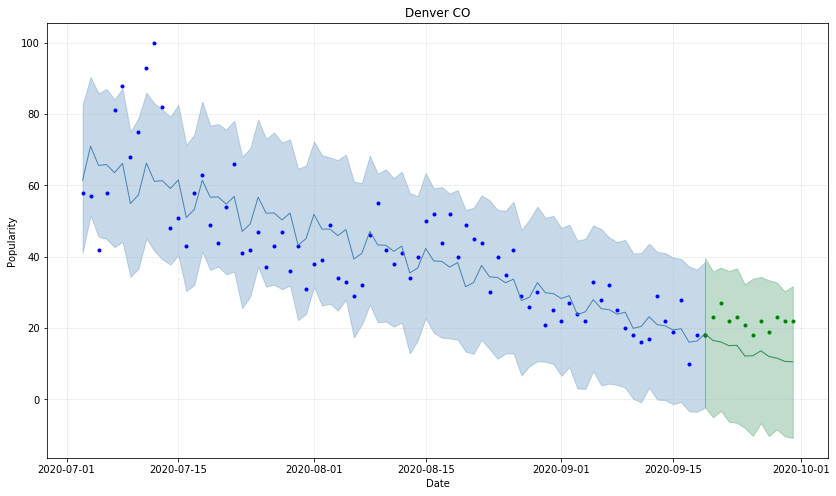

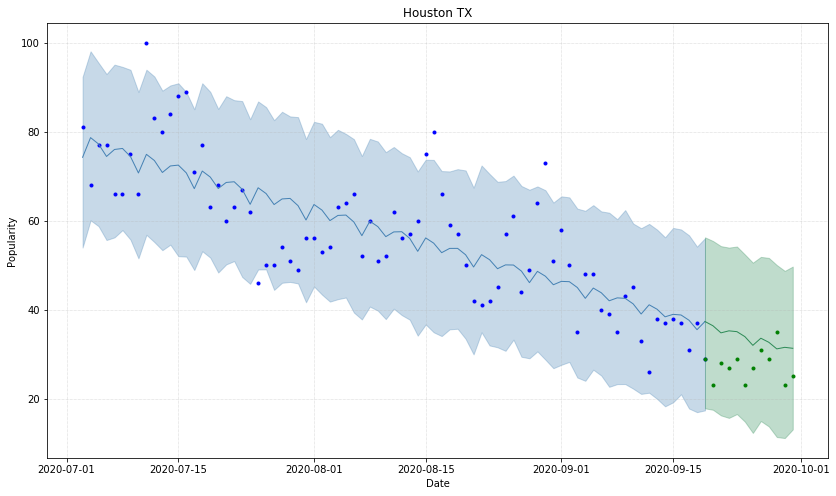

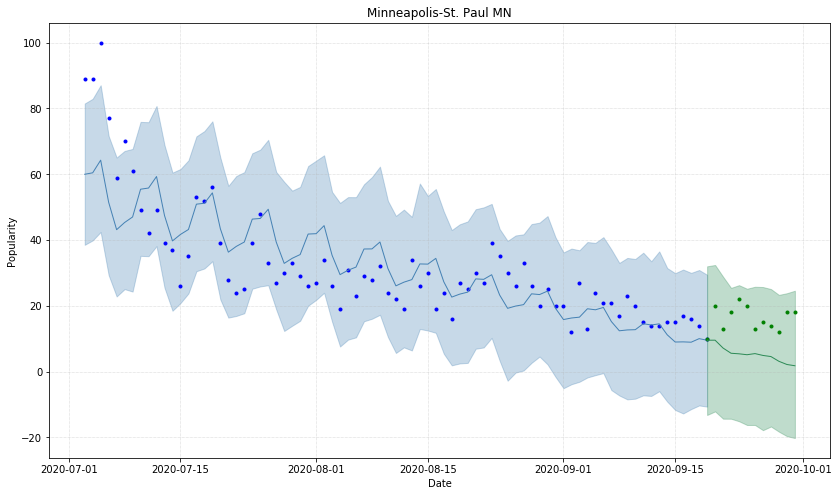

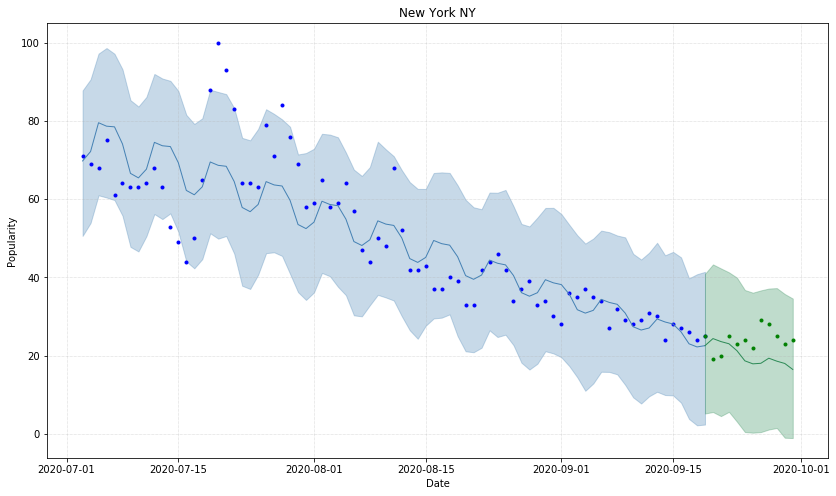

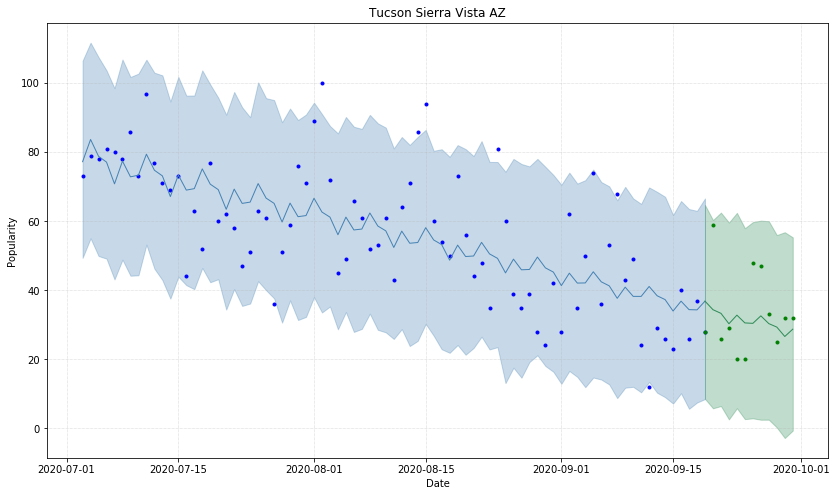

In [10]:
tables_perf_no_regr = {}
for i in train_tables.keys():
    print(i)
    model = Prophet(**best_params, interval_width=0.95)
    model.fit(train_tables[i])  
    future_dates = model.make_future_dataframe(periods=12, freq = 'D') #choose dates to predict
    pred = model.predict(test_tables[i])
    df_cv = cross_validation(model, horizon='10 days', parallel="processes") #metrics
    tables_perf_no_regr[i] = performance_metrics(df_cv, rolling_window=.5) #metrics
    #for adjusting the frequency use python aliases below.
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    
    f, ax = plt.subplots(figsize=(14, 8))
    train = model.predict(train_tables[i]).set_index('ds')
    test = model.predict(test_tables[i]).set_index('ds')
    ax.plot(train.index, train_tables[i].y, 'bo', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=1)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    ax.plot(test.index, test_tables[i].y, 'go', markersize=3)
    ax.plot(test.index, test.yhat, color='seagreen', lw=1)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='seagreen', alpha=0.3)
    ax.grid(ls=':', lw=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Popularity')
    ax.set_title(str(i))

# Selecting additional data to feed the model

### Correlation assessment  

Below we see a medium correlation of .44 between temperature and searches for 'AC' (represented as 'y')

In [ ]:
df[variables].corr()

### Forecasts with temperature as an added regressor 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Atlanta GA


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D1AB7AC8>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Denver CO


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226CFAF76C8>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Houston TX


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D220E988>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Minneapolis-St. Paul MN


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D2230F48>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


New York NY


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226D01BC888>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Tucson Sierra Vista AZ


INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-07-29 00:00:00 and 2020-09-11 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000226CF9D8C48>


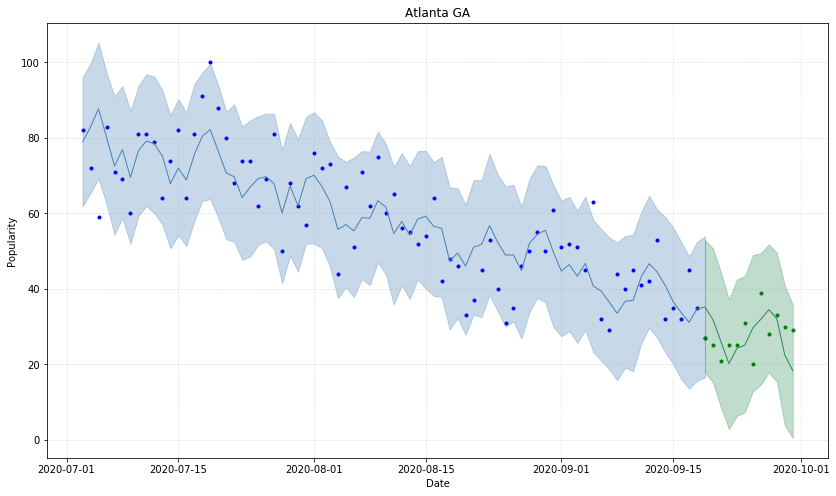

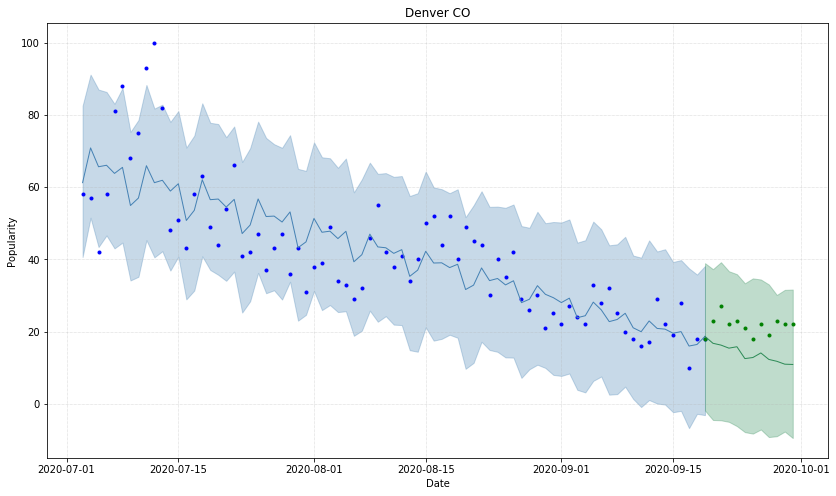

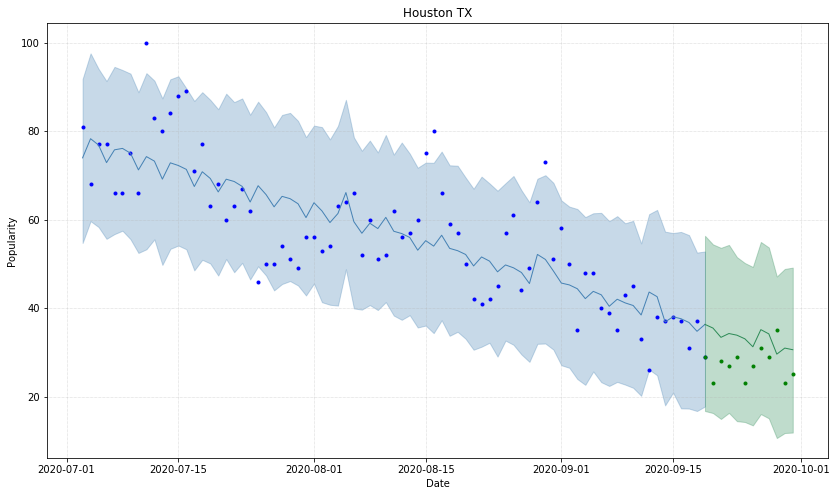

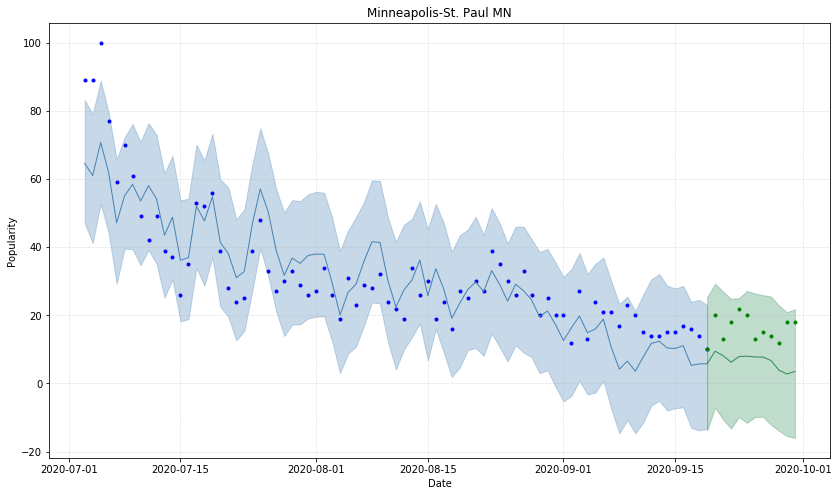

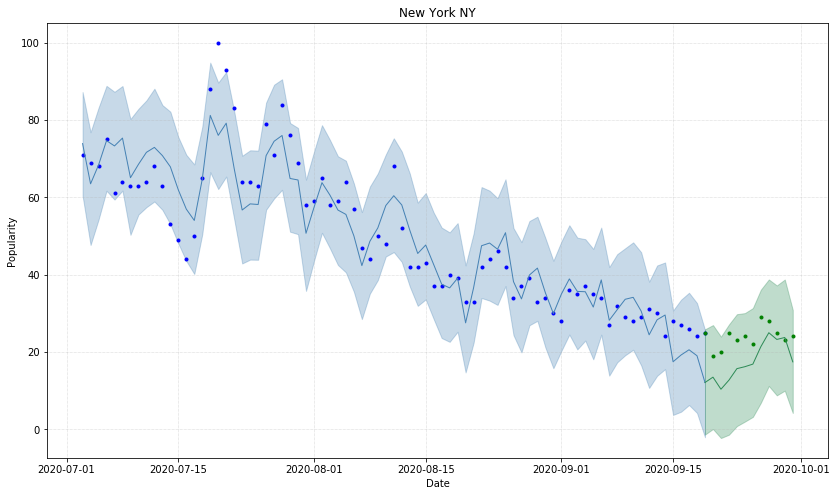

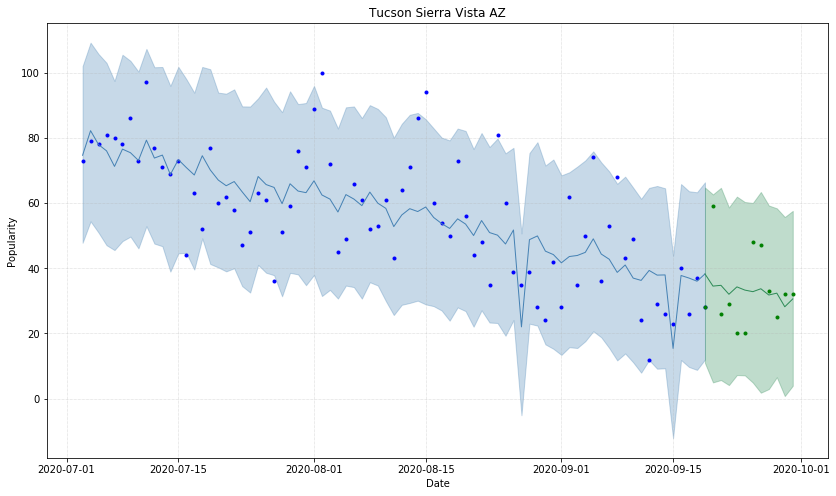

In [11]:
tables_perf = {}
for i in train_tables.keys():
    print(i)
    model = Prophet(**best_params, interval_width=0.95)
    model.add_regressor('TOBS') #add Temperature as regressor¿
    model.fit(train_tables[i])  
    future_dates = model.make_future_dataframe(periods=12, freq = 'D') #choose dates to predict
    pred_reg = model.predict(test_tables[i])
    #fig = model.plot_components(forecast)
    df_cv_reg = cross_validation(model, horizon='8 days', parallel="processes") #metrics
    tables_perf[i] = performance_metrics(df_cv_reg, rolling_window=1) #metrics
    #for adjusting the frequency use python aliases below.
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    
    f, ax = plt.subplots(figsize=(14, 8))
    train = model.predict(train_tables[i]).set_index('ds')
    test = model.predict(test_tables[i]).set_index('ds')
    ax.plot(train.index, train_tables[i].y, 'bo', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=1)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    ax.plot(test.index, test_tables[i].y, 'go', markersize=3)
    ax.plot(test.index, test.yhat, color='seagreen', lw=1)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='seagreen', alpha=0.3)
    ax.grid(ls=':', lw=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Popularity')
    ax.set_title(str(i))

## Results

Based on the medium absolute percentage error (MAPE) we see that in five out of 6 locations have by adding temperature as an additional regressor in the model. Overall, we do see a slight improvement in the model. However, I've been disapointed in the added accuracy produced prophet's add_regressor capability. Considering there was a .44 correlation with the target variable I would have expected more improvement. 

This method assumes we would have weather forecasts which we could feed the model prior to prediction. If the regressor could not be provided in advance we would either forego using an added regressor or we would look outside of Prophet and use a method like Vector AutoRegression where both the target variable and the regressor variable influence each other and would be modeled together. 

In [ ]:
for i in tables_perf:
    print(i)
    print(round(tables_perf_no_regr[i].mape.mean(), 4))
    print(round(tables_perf[i].mape.mean(),4))
    print()

Now for city we have a table of predictions (yhat), interval ranges (yhat_lower, yhat_upper), along with the effects of each trend element. We can now easily pass these forecasts on for downstream uses and analysis. 

In [ ]:
pd.set_option('display.max_columns', None)
pred_reg.head()

Thanks for following along!